In [1]:
from docplex.mp.model import Model
from docplex.mp.conflict_refiner import ConflictRefiner

import itertools as iter
from itertools import product

import time
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay
from scipy.stats import norm
from scipy.optimize import linprog

import random

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D

In [2]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar 
	f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
	return f

def df1dy (x,y): #funcion a evaluar 
	f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
	return f

def gradf(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y)])
def gradf2(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y),-1.0])

def fSH(a,x):
    return f(a) + np.dot(gradf(a),(x-a))

def to_points(triangulo):
    puntos = triangulo.points
    simplices = triangulo.simplices

    lista = []

    for pp in simplices:
        a = puntos[pp[0]]
        b = puntos[pp[1]]
        c = puntos[pp[2]]

        lista.append([a,b,c])

    return lista

In [3]:
class Tree(object):
    "Generic tree node."
    def __init__(self, name='root', children=None):
        self.name = name
        self.children = []
        if children is not None:
            for child in children:
                self.add_child(child)
    def __repr__(self):
        return self.name
    def add_child(self, node):
        assert isinstance(node, Tree)
        self.children.append(node)
    
    def prone(self, leaf):
        self.children.remove(leaf)

In [4]:
#Primera pasada

k=0

data = dict()

X = dict()
Y = dict()
D = dict()

lb = float(1.0e-4)
ub = float(5.0)

a = np.array([lb,lb])
b = np.array([ub,ub])

X[k] = a #R^2
Y[k] = 0.0 #R

D[k] = 1

deltaabs = np.infty
deltarel = np.infty

epsabs = 1.0e-5 #No cambiar
epsrel = 1.0e-4

data[k] = {"OI": int(k), "X" :  X[k], "Y": Y[k], "f(x)": f(X[k]), "difabs": f(a)-0.0, "difrel": 1}


while k < 1e6:
    Terminar = False

    soluciones = dict()

    p = X[k]

    for i in [1,2]:
        e_i = np.zeros(2)
        e_i[i-1] = float(1.0)
        for c in [lb,ub]:
            
            lhsA = np.array([gradf(p),
                            e_i])
            rhsb = np.array([np.dot(gradf(p),p)-f(p), c])

            ecs = np.linalg.solve(lhsA,rhsb)
            way = max(fSH(p,ecs),0.0)

            if np.less_equal(a/2.0,ecs).all() and np.less_equal(ecs,b+a/2.0).all():
                soluciones[str(ecs)] = (ecs,way)

    if len(soluciones) < 1.0:
        ecs_s = b
        way_s = max(fSH(p,b),0)
        Terminar = True

    else:
        maximo = -1*np.infty
        for key in soluciones.keys():
            val = soluciones[key]
            if val[1] > maximo:
                maximo = val[1]
                ecs_s = val[0]
                way_s = maximo
    
    deltaabs = f(ecs_s)-way_s
    deltarel = deltaabs/f(ecs_s)

    k+=1
    
    X[k] = ecs_s
    Y[k] = way_s
    
    if deltaabs <= epsabs or deltarel <= epsrel:
        D[k] = 0
        Terminar = True

    data[k] = {"OI": int(k), "X" :  X[k], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}

    if Terminar:
        break

df = pd.DataFrame(data).transpose()

In [5]:
print(df.to_markdown())

|     |   OI | X                               |           Y |        f(x) |      difabs |   difrel |
|----:|-----:|:--------------------------------|------------:|------------:|------------:|---------:|
|   0 |    0 | [0.0001 0.0001]                 | 0           | 0.398867    | 0.398867    |        1 |
|   1 |    1 | [1.00000000e-04 1.59578135e+00] | 0           | 0.398867    | 0.151059    |        1 |
|   2 |    2 | [1.00000000e-04 3.48508512e+00] | 0           | 0.151059    | 0.0717185   |        1 |
|   3 |    3 | [1.25293162e+00 1.00000000e-04] | 0           | 0.0717185   | 0.0502727   |        1 |
|   4 |    4 | [1.00000000e-04 3.46246944e+00] | 0           | 0.0502727   | 0.0721866   |        1 |
|   5 |    5 | [1.25289552e+00 1.00000000e-04] | 2.77556e-17 | 0.0721866   | 0.0502765   |        1 |
|   6 |    6 | [1.00000000e-04 3.46241033e+00] | 2.77556e-17 | 0.0502765   | 0.0721878   |        1 |
|   7 |    7 | [1.25289542e+00 1.00000000e-04] | 0           | 0.0721878   | 0.050

c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


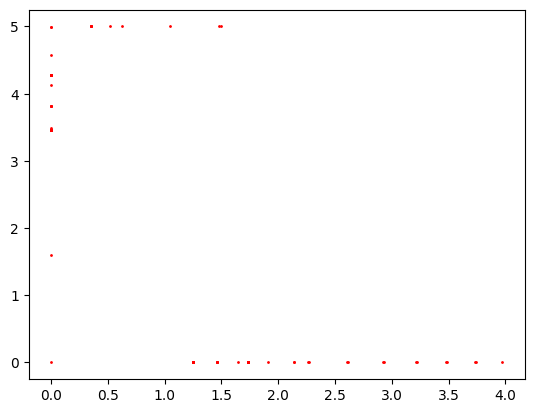

In [6]:
ex = df["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append((x[0]))
    py.append((x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

In [7]:
puntos_iniciales = df["X"].values.tolist()

#puntos_iniciales.append(np.array([lb,ub]))
#puntos_iniciales.append(np.array([ub,lb]))
puntos_iniciales = np.array(puntos_iniciales)

tri_inicial = Delaunay(puntos_iniciales, incremental= False)

In [8]:
puntos_iniciales2 = np.log10(puntos_iniciales)

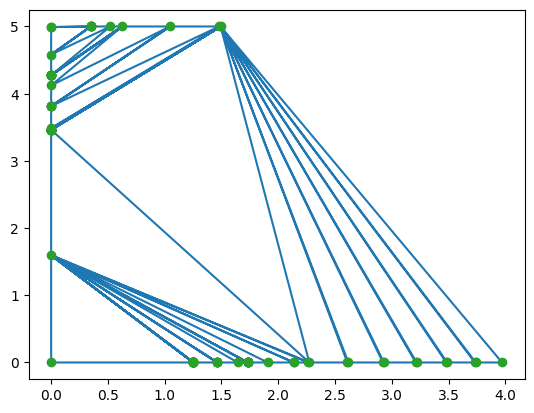

In [9]:
plt.triplot(puntos_iniciales[:,0], puntos_iniciales[:,1], tri_inicial.simplices)
plt.plot(puntos_iniciales[:,0], puntos_iniciales[:,1], 'o')
plt.show()

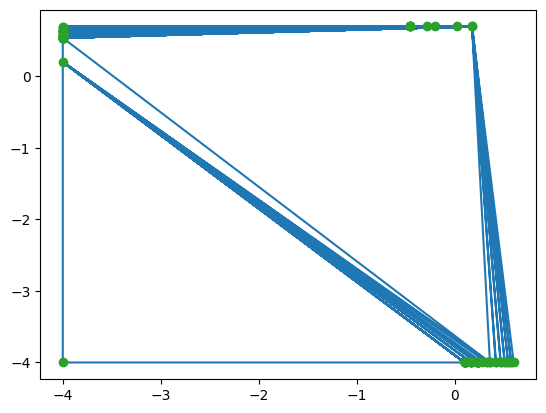

In [10]:
plt.triplot(puntos_iniciales2[:,0], puntos_iniciales2[:,1], tri_inicial.simplices)
plt.plot(puntos_iniciales2[:,0], puntos_iniciales2[:,1], 'o')
plt.show()

In [11]:
#Segunda pasada
simplices = to_points(tri_inicial)

for simplex in simplices:
    v = dict()
    v[1] = simplex[0]
    v[2] = simplex[1]
    v[3] = simplex[2]

    lhsA = np.array([gradf2(v[1]),
                     gradf2(v[2]),
                     gradf2(v[3])])
    rhsb = np.array([np.dot(gradf(v[1]),v[1])-f(v[1]),
                     np.dot(gradf(v[2]),v[2])-f(v[2]),
                     np.dot(gradf(v[3]),v[3])-f(v[3])])

    sol = np.linalg.solve(-lhsA,-rhsb)
    ecs = sol[0:2]
    way = max(sol[2],0.0)
    
    A = np.array([[v[1][0], v[2][0], v[3][0]],
                [v[1][1], v[2][1], v[3][1]],
                np.ones(3).T])
    
    beq = np.array([ecs[0],ecs[1],np.ones(1)]) 	

    isinConvH = linprog(np.zeros(3),A_eq=A,b_eq=beq, options = {"tol" : 1.0e-5, "autoscale": True}).success
    
    N = 0
    
    if isinConvH:   ################# 
        ecs_s = ecs
        way_s = way
    else:
        maximo = 0.0
        for n in v.keys():
            lhsA2 = np.copy(lhsA)
            rhsb2 = np.copy(rhsb)
            
            vi = v[n%3+1]
            vj = v[(n+1)%3+1]

            lhsA2[n-1] = np.array([vi[0]-vj[0],vi[1]-vj[1],np.zeros(1)])
            rhsb2[n-1] = np.zeros(1)
    
            sol = np.linalg.solve(lhsA2,rhsb2)
            
            ecs = sol[0:2]
            way = sol[2]
            
            A = np.array([[vi[0], vj[0]],
                          [vi[1], vj[1]],
                          np.ones(2).T])
    
            beq = np.array([ecs[0],ecs[1],np.ones(1)]) 	
            isinConvH2 = linprog(np.zeros(2),A_eq=A,b_eq=beq, options = {"tol" : 1.0e-5, "autoscale": True}).success

            if not isinConvH2:
                dist1 = np.linalg.norm(vi-ecs)
                dist2 = np.linalg.norm(vj-ecs)
                dist3 = np.linalg.norm(vj-vi)

                distab = abs(dist2+dist1-dist3)

                isinConvH2 = distab<1.0e-4 or distab/dist3<1.0e-3

            if f(ecs)-way > maximo and isinConvH2:
                if np.less_equal(a/2.0,ecs).all() and np.less_equal(ecs,b+a/2.0).all():
                    maximo = f(ecs)-way
                    ecs_s = ecs
                    way_s = way
                    N = n
    
    #print(isinConvH2.success)
    #print(isinConvH2)

    deltaabs = f(ecs_s) - max(way_s,0.0)
    deltarel = deltaabs/f(ecs_s)
    
    if deltaabs <= epsabs or deltarel <= epsrel or (N==0 and not isinConvH):
        continue

    k+=1
    
    if ecs_s[0] < 1.0e-4:
        ecs_s[0] = 1.0e-4

    X[k] = ecs_s
    Y[k] = way_s

    data[k] = {"OI": int(k), "X" :  X[k], "Y": Y[k],"f(x)": f(ecs_s),"difabs": deltaabs, "difrel":deltarel}
    
    for n in v.keys():
        if n != N:
            vi = v[n%3+1]
            vj = v[(n+1)%3+1]
            simplices = np.append(simplices, np.array([[ecs_s,vi,vj]]), axis=0)
            #simplices = np.append(simplices, np.array([[v[1],ecs_s,v[3]]]), axis=0)
            #simplices = np.append(simplices, np.array([[v[1],v[2],ecs_s]]), axis=0)
    if k+1 == 800:
        break
df2 = pd.DataFrame(data).transpose()

c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [12]:
print(k)
print(len(df2))
print(len(simplices))

132
133
91


In [13]:
print(df2.to_markdown())

|     |   OI | X                               |           Y |        f(x) |      difabs |   difrel |
|----:|-----:|:--------------------------------|------------:|------------:|------------:|---------:|
|   0 |    0 | [0.0001 0.0001]                 | 0           | 0.398867    | 0.398867    | 1        |
|   1 |    1 | [1.00000000e-04 1.59578135e+00] | 0           | 0.398867    | 0.151059    | 1        |
|   2 |    2 | [1.00000000e-04 3.48508512e+00] | 0           | 0.151059    | 0.0717185   | 1        |
|   3 |    3 | [1.25293162e+00 1.00000000e-04] | 0           | 0.0717185   | 0.0502727   | 1        |
|   4 |    4 | [1.00000000e-04 3.46246944e+00] | 0           | 0.0502727   | 0.0721866   | 1        |
|   5 |    5 | [1.25289552e+00 1.00000000e-04] | 2.77556e-17 | 0.0721866   | 0.0502765   | 1        |
|   6 |    6 | [1.00000000e-04 3.46241033e+00] | 2.77556e-17 | 0.0502765   | 0.0721878   | 1        |
|   7 |    7 | [1.25289542e+00 1.00000000e-04] | 0           | 0.0721878   | 0.050

### POR QUE HAY VALORES NEGATIVOS?

Por mientras, los parchearé a la mala...

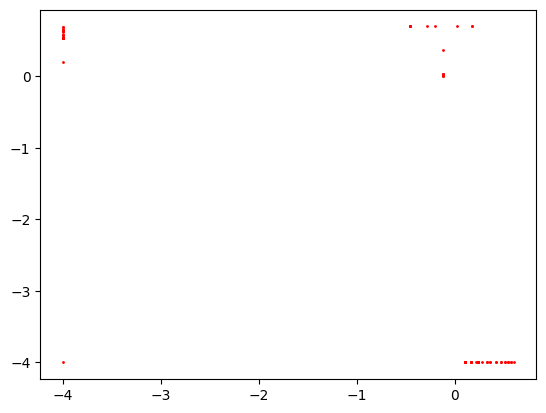

In [14]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(np.log10(x[0]))
    py.append(np.log10(x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

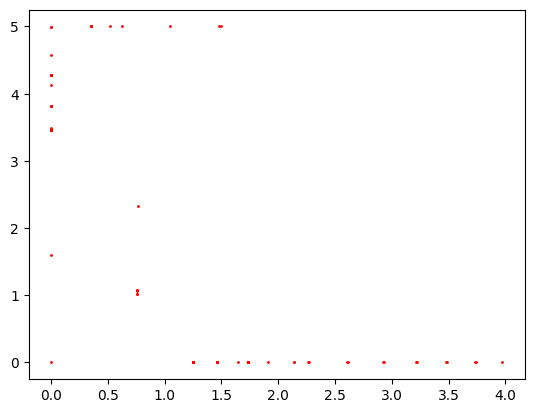

In [15]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(x[0])
    py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

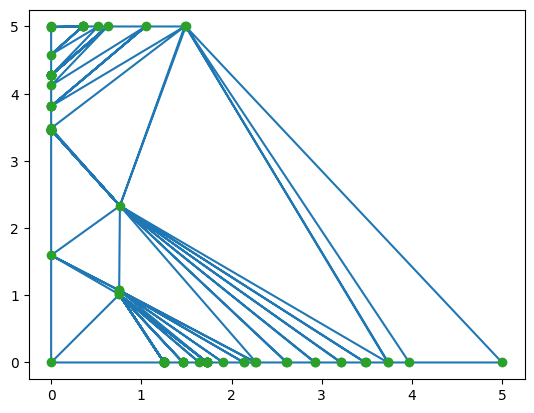

In [16]:
pepes = df2["X"].values.tolist()

pepes.append(np.array([lb,ub]))
pepes.append(np.array([ub,lb]))
pepes = np.array(pepes)

tri2 = Delaunay(pepes, incremental= False)
plt.triplot(pepes[:,0], pepes[:,1], tri2.simplices)
plt.plot(pepes[:,0], pepes[:,1], 'o')
plt.show()

In [17]:
print(len(df2)-len(df), len(df))

6 127


In [18]:
puntox1  = np.random.rand(1000,2)*(ub-lb)+lb
puntox2  = []

for n in puntox1:
    puntox2.append(np.array([n[0], n[1], f(n)]))
puntox2 = np.array(puntox2)


c:\Users\nico_\anaconda3\envs\Cplex\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  after removing the cwd from sys.path.


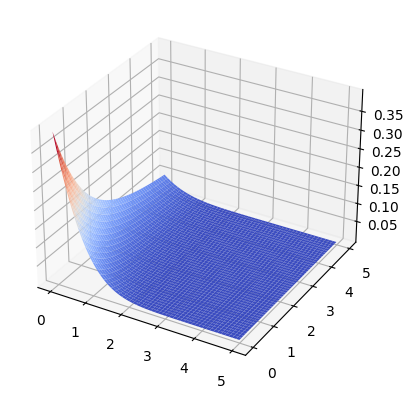

In [19]:
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

#X = puntox2[:,0]
X = np.arange(lb, ub, 0.01)
Y = np.arange(lb, ub, 0.01)
#Y = puntox2[:,1]

X,Y = np.meshgrid(X,Y)

Z = f((X,Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()
